# SMCNOD
This notebook presents the mixture model of 3 gaussians built for SMCNOD data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [3]:
len(tab)

291

In [4]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

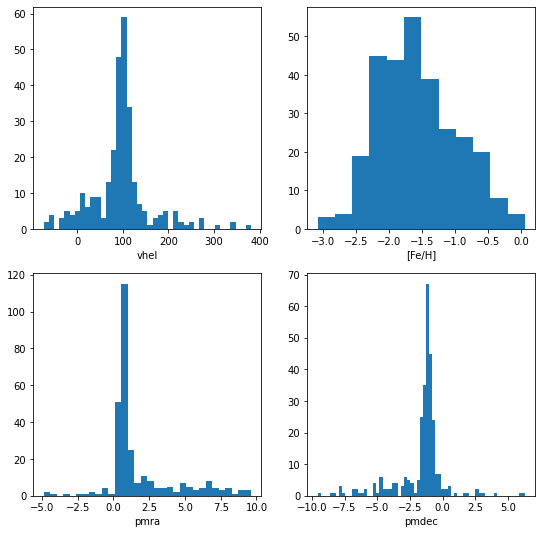

In [5]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In the given code, pmnorm is defined as 1/(np.pi * pmmax**2), where pmmax is the magnitude of the maximum proper motion vector. This expression is used to normalize the proper motion likelihood function for the entire data set.

In more detail, the proper motion likelihood function represents the probability of observing a particular proper motion vector for a star, given its position on the sky and any other relevant information. In this code, a uniform background distribution is assumed, which means that the likelihood of observing any particular proper motion vector is assumed to be constant across the entire sky.

To normalize the proper motion likelihood function, the maximum value of the proper motion vector magnitude is computed (pmmax), and the inverse of the product of pi and the square of pmmax is taken (1/(np.pi * pmmax**2)). This value (pmnorm) is then used to scale the proper motion likelihood function so that its integral over the entire sky is equal to one. This ensures that the probability of observing any proper motion vector is properly normalized, given the assumptions made in the analysis.

In [6]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
# pms array is computed and assigned to the variable pmmax. 
# This is essentially finding the magnitude of the maximum proper motion vector.
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
# normalize the proper motion likelihood function for the entire data set
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

We will model the smcnod data as a mixture of 2 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component

# Likelihood function

In [7]:
#use a dictionary to store data, make the code more organized, easier to read, and more flexible.
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [8]:
param_labels = ["pgal",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "pmra","pmdec",
                "pmra1","pmdec1","lsigpmra1","lsigpmdec1"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, lsigpmra1, lsigpmdec1 = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2) or \
        (abs(pmra1) > 10) or (abs(pmdec1) > 10) or \
        (lsigpmra1 > 1.3) or (lsigpmra1 < -1) or \
        (lsigpmdec1 > 1.3) or (lsigpmdec1 < -1) :
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pmra = stats.norm.logpdf(pmra, loc=pmra1, scale=np.sqrt(pmraerr**2 + (10**lsigpmra1)**2))
    lbg1_pmdec = stats.norm.logpdf(pmdec, loc=pmdec1, scale=np.sqrt(pmdecerr**2 + (10**lsigpmdec1)**2))
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+lgal_feh
    lbg1 = np.log(1-pgal)+lbg1_vhel+lbg1_pmra+lbg1_pmdec+lbg1_feh
    ltot = np.logaddexp(lgal, lbg1)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [19]:
def project_model(theta, rvmin=-100, rvmax=400, fehmin=-3, fehmax=0):
    """ Turn parameters into rv and feh distributions """
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    params = get_paramdict(theta)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])

    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    return rvarr, prv0, prv1,feharr, pfe0, pfe1

In [20]:
def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins=200)
    xp, p0, p1 = model_output[0:3]
    ax.plot(xp, p0 + p1, 'k-', label="Total", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1 = model_output[3:6]
    ax.plot(xp, p0 + p1, 'k-', lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    return fig

In [15]:
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.grid()

# Optimize parameters



In [30]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.47, 
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.1,
            0.7, -1.1,
            0.7, -1, 1, 1]

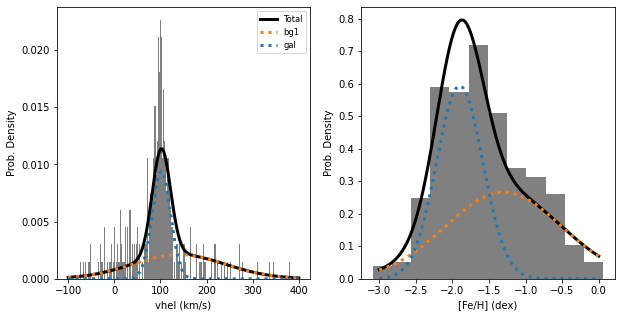

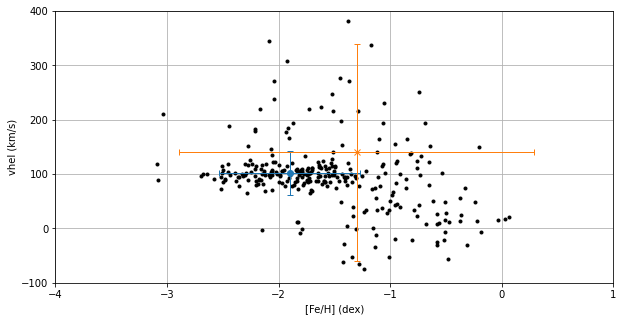

In [31]:
fig1 = plot_1d_distrs(p0_guess)
fig2 = plot_2d_distr(p0_guess)

In [32]:
optfunc = lambda theta: -full_like(theta)

In [33]:
%timeit optfunc(p0_guess)

19.9 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
optfunc(p0_guess)

2695.062506507572

In [35]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 58.8 s, sys: 1.22 s, total: 1min
Wall time: 1min


In [36]:
res.x

array([ 0.55348421, 99.19971532,  1.16312836, -1.87211339, -0.47372787,
       82.86989358,  1.97955747, -1.05467243, -0.15389898,  0.69550643,
       -1.12388253,  1.55625137, -1.06445474,  0.54834916,  0.46661839])

In [37]:
optfunc(res.x)

2495.024093921772

In [38]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.553
vhel: 99.200
lsigv: 1.163
feh: -1.872
lsigfeh: -0.474
vbg1: 82.870
lsigvbg1: 1.980
fehbg1: -1.055
lsigfeh1: -0.154
pmra: 0.696
pmdec: -1.124
pmra1: 1.556
pmdec1: -1.064
lsigpmra1: 0.548
lsigpmdec1: 0.467


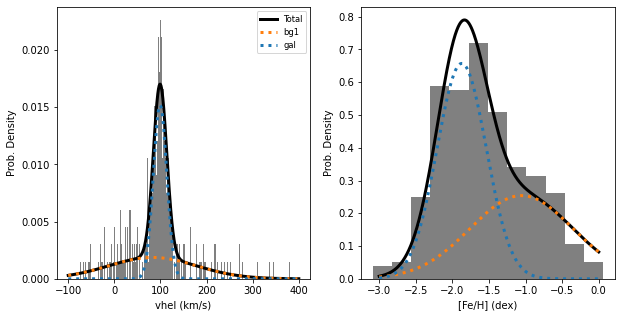

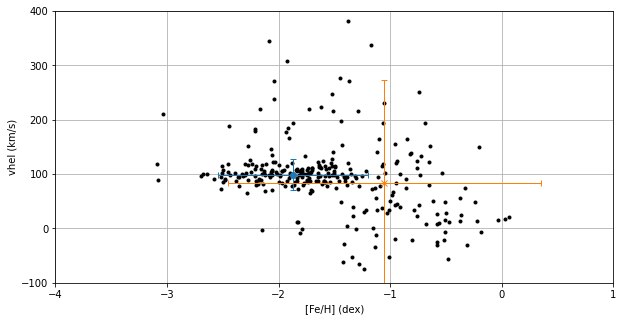

In [40]:
fig1 = plot_1d_distrs(res.x)
fig2 = plot_2d_distr(res.x)

## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [41]:
nw = 64
p0 = res['x']
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
print(p0s)

[[ 4.88798463e-01  1.02006262e+02  1.26916342e+00 -1.89843580e+00
  -4.95312562e-01  1.39982431e+02  2.00712860e+00 -1.30259378e+00
  -1.14719487e-01  7.35467051e-01 -1.05214887e+00  7.15049666e-01
  -1.00276823e+00  1.01263356e+00  1.02517732e+00]
 [ 4.61711160e-01  1.01996026e+02  1.29542074e+00 -1.88009227e+00
  -4.98731756e-01  1.40004747e+02  1.99192633e+00 -1.30577541e+00
  -6.86195784e-02  7.08748000e-01 -1.09066695e+00  7.42944490e-01
  -1.01067859e+00  9.99703539e-01  9.95612449e-01]
 [ 4.96670932e-01  1.01985722e+02  1.29512200e+00 -1.82815592e+00
  -4.83789984e-01  1.39985433e+02  1.99404314e+00 -1.29952437e+00
  -7.33015719e-02  6.98333144e-01 -1.08747571e+00  6.84608351e-01
  -9.75619189e-01  9.72598857e-01  1.01260956e+00]
 [ 5.05838369e-01  1.01982885e+02  1.27339479e+00 -1.90157031e+00
  -4.73335838e-01  1.39998557e+02  2.03032596e+00 -1.27920919e+00
  -8.72405732e-02  7.16859354e-01 -1.12270393e+00  6.95208316e-01
  -1.00180715e+00  9.87322692e-01  9.43633828e-01]
 [ 5

In [42]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

15


In [43]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
from schwimmbad import MultiPool
pool = MultiPool(8)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [44]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 41min 3s, sys: 41 s, total: 41min 44s
Wall time: 41min 45s


In [45]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
#np.save("results_smcnod.npy",es.flatchain)

CPU times: user 40min 43s, sys: 10.2 s, total: 40min 53s
Wall time: 40min 51s


State([[  0.56275665  97.95776042   1.18235241  -1.86379746  -0.52197318
   73.69975019   1.98582821  -1.14871966  -0.26689539   0.71738823
   -1.12753001   3.76901894  -2.28799911   0.50303707   0.43728869]
 [  0.55485844 100.41778383   1.21825483  -1.91827519  -0.45866254
   90.04882318   1.98685211  -1.19025381  -0.15789049   0.72806891
   -1.13504969   2.68793074  -2.64789247   0.4986052    0.45823919]
 [  0.61797009 100.81520958   1.1742764   -1.85268653  -0.49613657
   71.69860532   1.9775071   -1.05440393  -0.2782035    0.69396252
   -1.13342951   3.28020024  -2.32144399   0.5439032    0.52452298]
 [  0.54375509 100.84520265   1.2356661   -1.88353152  -0.5284938
   71.50862598   1.98771957  -1.01466526  -0.16531088   0.70623828
   -1.14485468   2.85076757  -2.17506596   0.54899847   0.41781777]
 [  0.59132751  99.97630585   1.29596539  -1.90003855  -0.54287156
   84.01215924   2.00719432  -1.05922706  -0.26346137   0.71266366
   -1.14144044   2.92669016  -2.17942589   0.52848077

In [46]:
outputs = es.flatchain

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [47]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.342


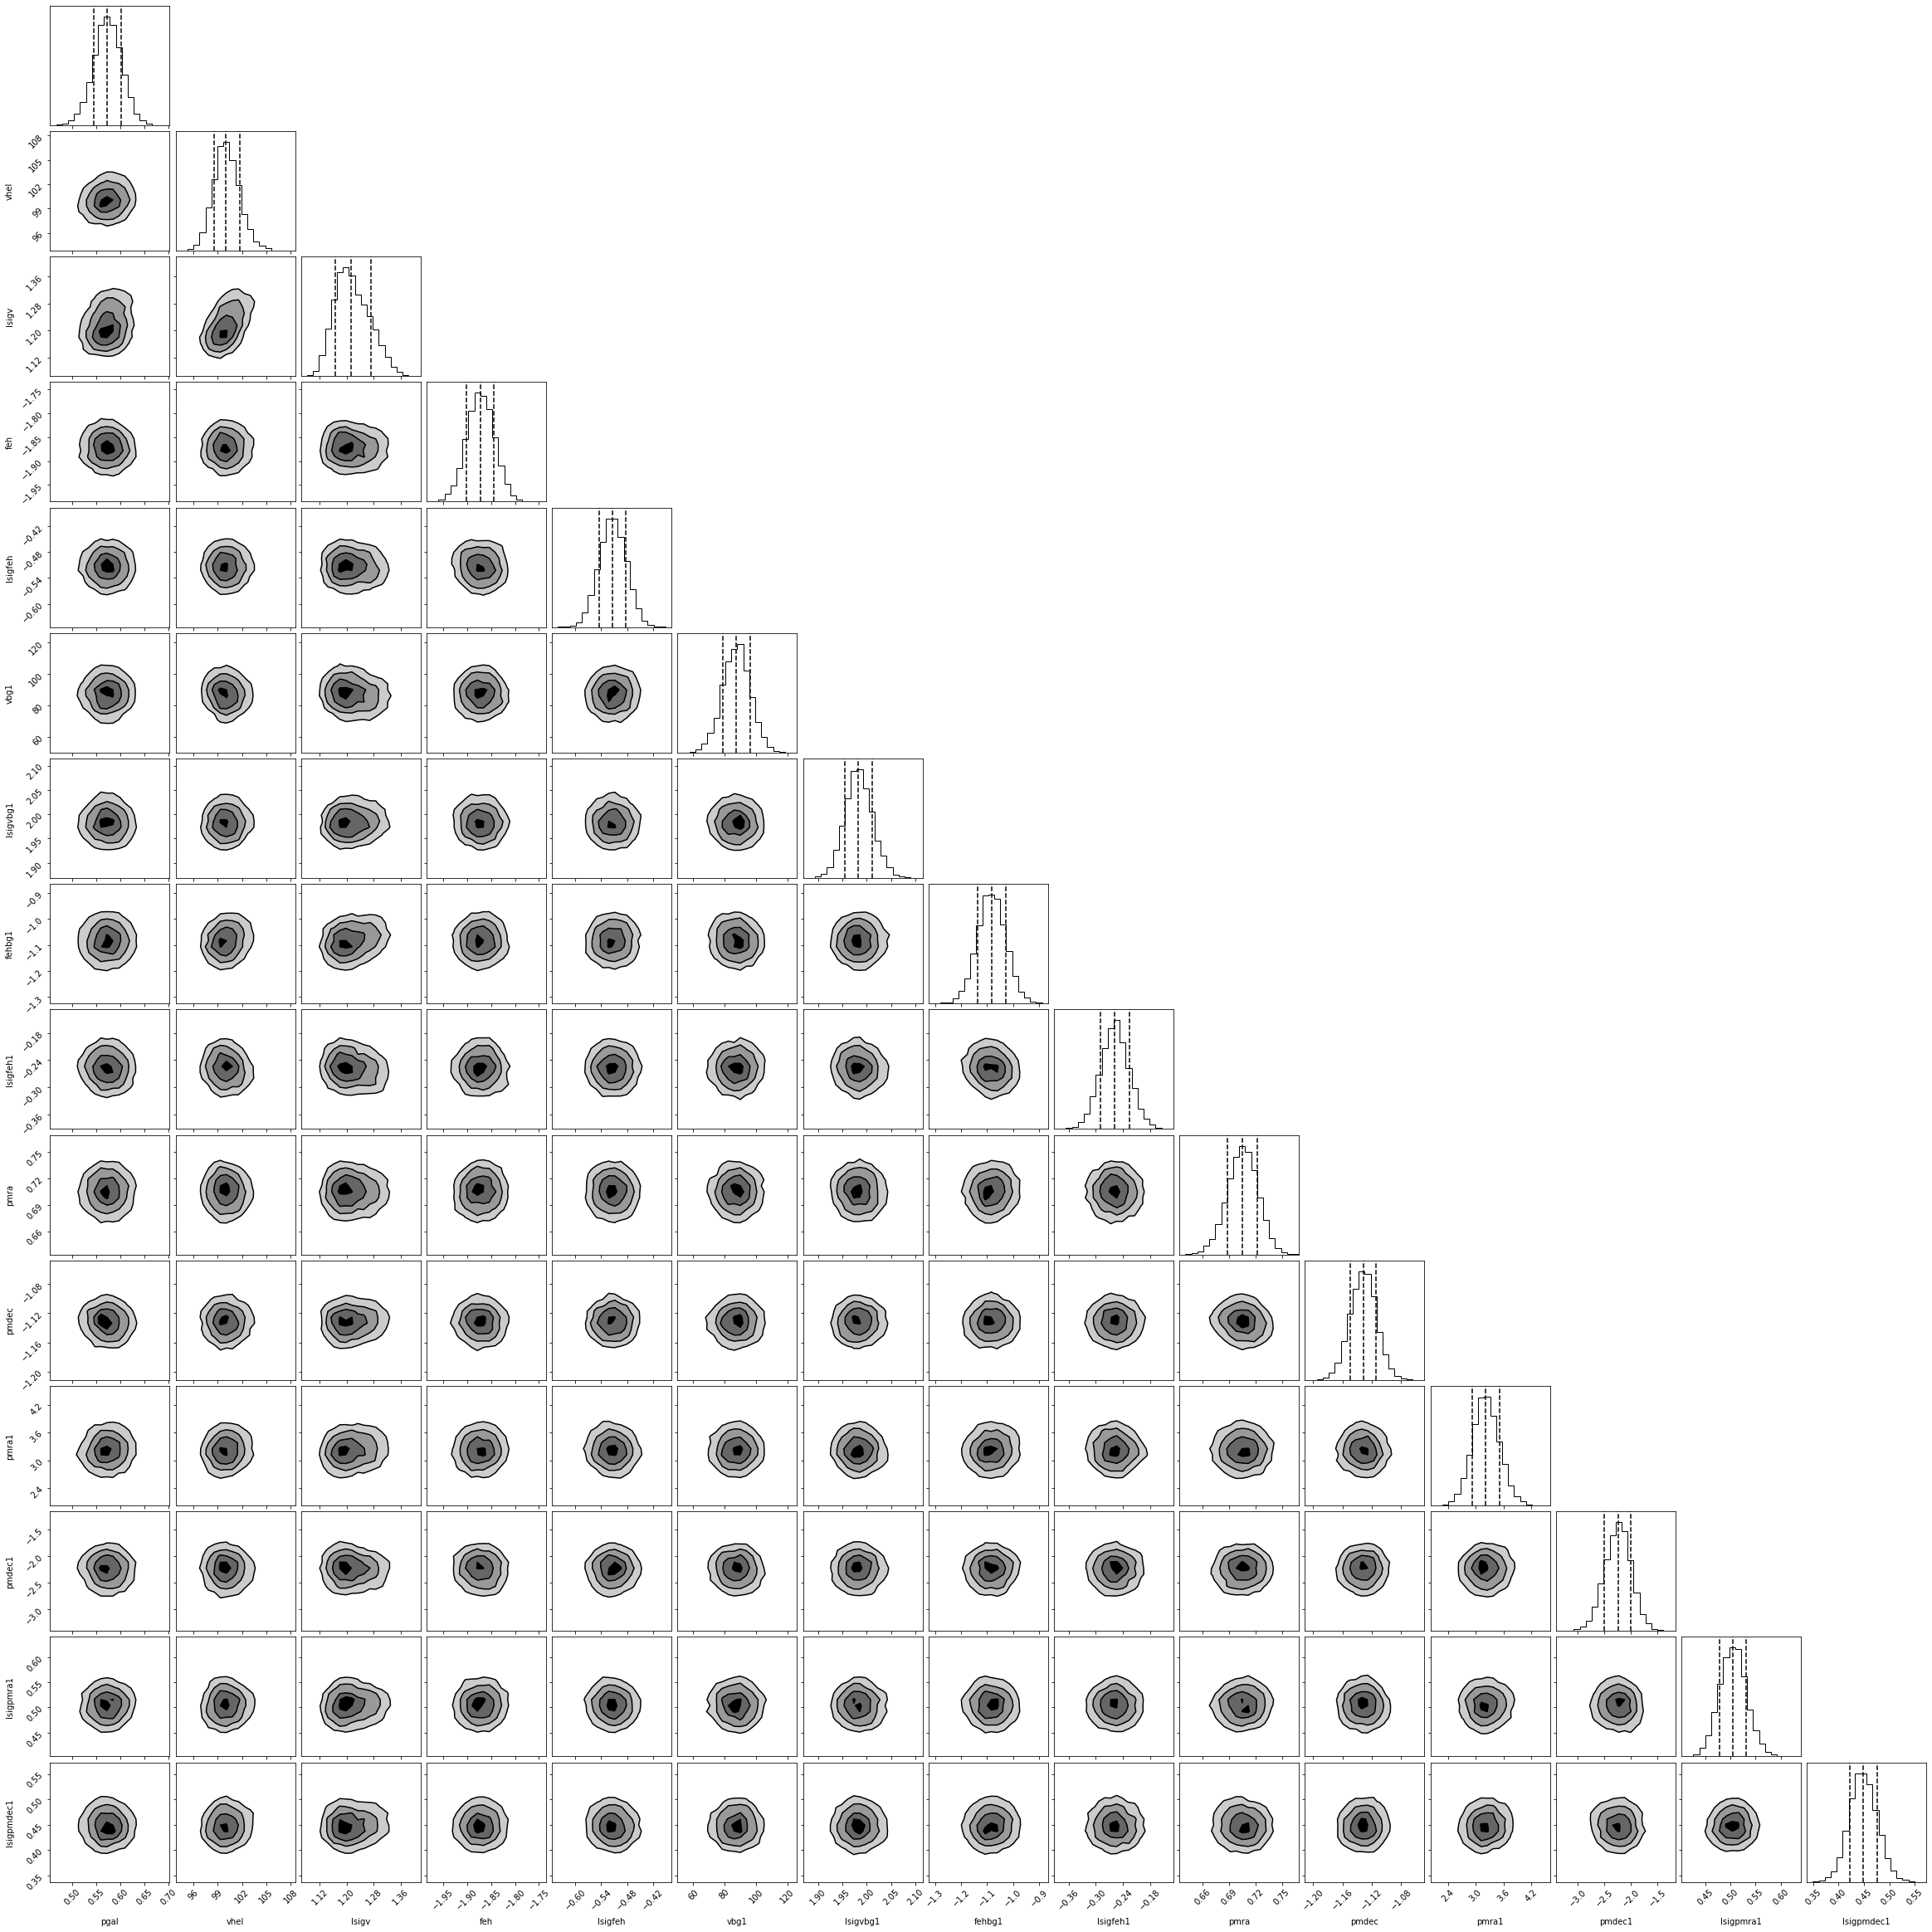

In [48]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
#plt.savefig('SMCNOD_PM_Model_Cornerplot.png')

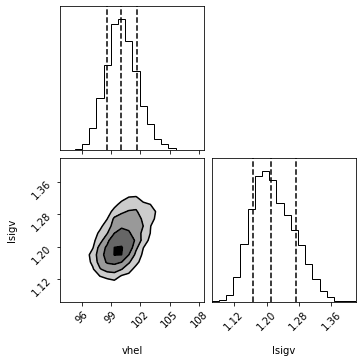

In [50]:
fig1 = corner.corner(outputs[:,1:3], labels=param_labels[1:3], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

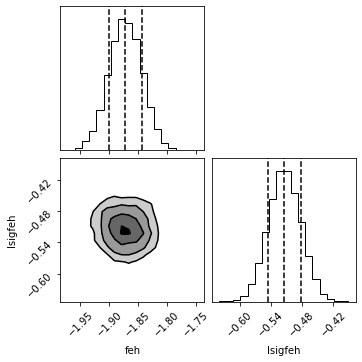

In [53]:
fig2 = corner.corner(outputs[:,3:5], labels=param_labels[3:5], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

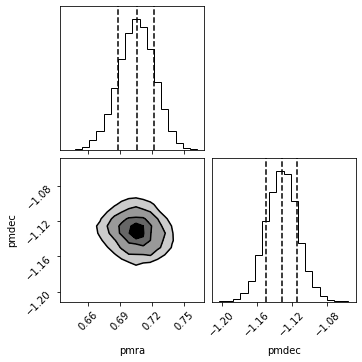

In [55]:
fig3 = corner.corner(outputs[:,9:11], labels=param_labels[9:11], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [56]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [57]:
meds, errs = process_chain(outputs)

In [58]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.573 0.029
vhel 100.036 1.573
lsigv 1.212 0.053
feh -1.872 0.029
lsigfeh -0.514 0.031
vbg1 87.511 8.754
lsigvbg1 1.983 0.028
fehbg1 -1.084 0.054
lsigfeh1 -0.258 0.032
pmra 0.706 0.017
pmdec -1.132 0.018
pmra1 3.215 0.292
pmdec1 -2.244 0.248
lsigpmra1 0.506 0.027
lsigpmdec1 0.448 0.027


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [59]:
chain = es.flatchain
chain.shape

(128000, 15)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

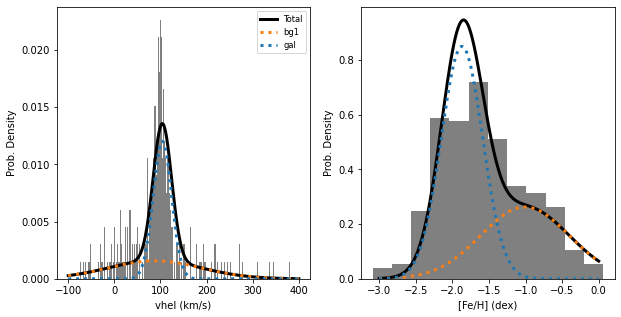

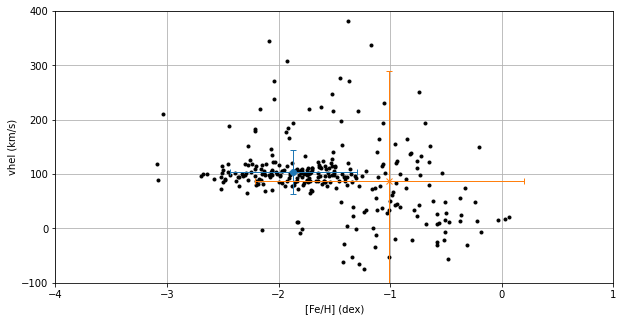

In [60]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

In [62]:
chain_new = 10**(chain)
mean_vdisp = np.percentile(chain_new[:,2], 50)
std_vdisp = (np.percentile(chain_new[:,2], 84)-np.percentile(chain_new[:,2], 16))/2
mean_fehdisp = np.percentile(chain_new[:,4], 50)
std_fehdisp = (np.percentile(chain_new[:,4], 84)-np.percentile(chain_new[:,4], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  16.286346702482522 std_vdisp:  2.0420280348726356
mean_fehdisp:  0.3064085216639345 std_fehdisp:  0.022154881151279837


In [63]:
param_labels_1 = ["pgal =",
                "vhel =","lsigv =","feh =","lsigfeh =",
                "vbg1 =","lsigvbg1 =","fehbg1 =","lsigfeh1 =",
                "pmra =","pmdec =",
                "pmra1 =","pmdec1 =","lsigpmra1 =","lsigpmdec1 ="]

def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal = 0.573
vhel = 100.036
lsigv = 1.212
feh = -1.872
lsigfeh = -0.514
vbg1 = 87.511
lsigvbg1 = 1.983
fehbg1 = -1.084
lsigfeh1 = -0.258
pmra = 0.706
pmdec = -1.132
pmra1 = 3.215
pmdec1 = -2.244
lsigpmra1 = 0.506
lsigpmdec1 = 0.448
